## Stable Model Training

#### NOTES:  
* This is "NoGAN" based training, described in the DeOldify readme.
* This model prioritizes stable and reliable renderings.  It does particularly well on portraits and landscapes.  It's not as colorful as the artistic model.

In [2]:
import os
from PIL import ImageFilter

os.environ['CUDA_VISIBLE_DEVICES']='0' 

import sys
sys.executable

'/opt/anaconda3/bin/python'

In [3]:
from tensorboardX import SummaryWriter

ModuleNotFoundError: No module named 'tensorboardX'

In [4]:
import fastai
from fastai import *
from fastai.vision import *

from fastai.vision.gan import *
from fasterai.generators import *
from fasterai.critics import *
from fasterai.dataset import *
from fasterai.loss import *
from fasterai.save import *
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFile

from fastai.callbacks.tensorboard import *

To use this tracker, please run 'pip install tensorboardx'. Also you must have Tensorboard running to see results


NameError: name 'SummaryWriter' is not defined

## Setup

In [6]:
base_path = Path('/mnt/disks/data/coco/')
path_hr = base_path/'train2017' #/mnt/disks/data/coco/train2017/ # /mnt/disks/data/lfw
path_lr = base_path/'bandw'
path_br = base_path/'blur'

proj_id = 'StableModel'

gen_name = proj_id + '_gen'
pre_gen_name = gen_name + '_0'
crit_name = proj_id + '_crit'

name_gen = proj_id + '_image_gen'
path_gen = base_path/name_gen

TENSORBOARD_PATH = Path('data/tensorboard/' + proj_id)

nf_factor = 2
pct_start = 1e-8

In [ ]:
path_gen

In [7]:
def get_data(bs:int, sz:int, keep_pct:float, task='blur'): # task = 'color' or 'blur'
    if task=='color':
        dest_path=path_lr
    elif task=='blur':
        dest_path=path_br
    return get_colorize_data(sz=sz, bs=bs, crappy_path=dest_path, good_path=path_hr, 
                             random_seed=None, keep_pct=keep_pct)

def get_crit_data(classes, bs, sz):
    src = ImageList.from_folder(path, include=classes, recurse=True).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=sz)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

def convert_bw(fn):
    return PIL.Image.open(fn).convert('LA').convert('RGB')

def convert_blur(fn, blur_radius=''):
    if not blur_radius:
        blur_radius = np.random*6+2 # random gen 2-8
    return PIL.Image.open(fn).filter(ImageFilter.GaussianBlur(blur_radius))

def create_training_images(fn,i,path, crap_function=convert_blur): # or convert_blur
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img=crap_function(fn)
    img.save(dest)  

    
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
    
def save_gen_images():
    if path_gen.exists(): shutil.rmtree(path_gen)
    path_gen.mkdir(exist_ok=True)
    data_gen = get_data(bs=bs, sz=sz, keep_pct=0.085)
    save_preds(data_gen.fix_dl)
    PIL.Image.open(path_gen.ls()[0])

In [12]:
path_gen

PosixPath('/mnt/disks/data/coco/StableModel_image_gen')

## Create black and white training images

Only runs if the directory isn't already created.

In [19]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz # get the data adnd move to a proper location
    # labeld faces in the wild

--2019-06-28 20:33:05--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  36.1MB/s    in 7.1s    

2019-06-28 20:33:13 (24.3 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [14]:

il = ImageList.from_folder(path_hr)
#parallel(create_training_images, il.items)
for i,item in  enumerate(il.items):
    create_training_images(item,0,path_br,crap_function=convert_blur)
    if i%1000==0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000


## Pre-train generator

#### NOTE
Most of the training takes place here in pretraining for NoGAN.  The goal here is to take the generator as far as possible with conventional training, as that is much easier to control and obtain glitch-free results compared to GAN training.

### 64px

In [10]:
bs=88
sz=64
keep_pct=1.0

In [9]:
data_gen = get_data(bs=bs, sz=sz, keep_pct=keep_pct)

In [10]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor)

In [15]:
#learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPre'))

In [16]:
learn_gen.fit_one_cycle(1, pct_start=0.8, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [ ]:
# saved in ls {learn_gen.path/learn_gen.model_dir}

In [ ]:
learn_gen.save(pre_gen_name)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=pct_start,  max_lr=slice(3e-7, 3e-4))

In [ ]:
learn_gen.save(pre_gen_name)

In [11]:
learn_gen.load(pre_gen_name)

Learner(data=ImageDataBunch;

Train: LabelList (53229 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: /mnt/disks/data/coco/blur;

Valid: LabelList (5914 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: /mnt/disks/data/coco/blur;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4)

### 128px

In [21]:
bs=20
sz=128
keep_pct=1.0

In [22]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

In [23]:
learn_gen.unfreeze()

In [24]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(1e-7,1e-4))

epoch,train_loss,valid_loss,time
0,1.440806,1.337963,40:07


In [25]:
learn_gen.save(pre_gen_name)

### 192px

In [26]:
bs=8
sz=192
keep_pct=0.50

In [27]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

In [28]:
learn_gen.unfreeze()

In [29]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(5e-8,5e-5))

epoch,train_loss,valid_loss,time
0,1.889275,1.803771,45:55


In [30]:
learn_gen.save(pre_gen_name)

### 224px

In [8]:
bs=4
sz=224
keep_pct=0.50

In [32]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

In [33]:
learn_gen.unfreeze()

In [34]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(2e-8,2e-5))

epoch,train_loss,valid_loss,time
0,2.065648,2.229414,1:08:48


In [35]:
self=learn_gen
self.path/self.model_dir

PosixPath('/mnt/disks/data/coco/blur/models')

In [36]:
learn_gen.save(pre_gen_name)

### Test our image

In [38]:
from fastai.vision.image import open_image

In [12]:
learn_gen.load('/mnt/disks/data/lfw/blur/models/StableModel_gen_0')

Learner(data=ImageDataBunch;

Train: LabelList (6470 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: /mnt/disks/data/lfw/blur;

Valid: LabelList (718 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: /mnt/disks/data/lfw/blur;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Se

In [88]:
!wget https://www.dropbox.com/s/48ico99sqpn9on1/IMG_20190625_214419.jpg?dl=1 # from dropbox

--2019-06-28 21:25:27--  https://www.dropbox.com/s/48ico99sqpn9on1/IMG_20190625_214419.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/48ico99sqpn9on1/IMG_20190625_214419.jpg [following]
--2019-06-28 21:25:27--  https://www.dropbox.com/s/dl/48ico99sqpn9on1/IMG_20190625_214419.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfed0f448324b6d6974e82652cd.dl.dropboxusercontent.com/cd/0/get/AjuvBGg3mVoS4ljh5q57YTvMI2FDLcANODqv6l07atvr4uBOEXrxP3FvV3zOjoCmp6vmndoP74pCQqq_Je4gbWcm2nJ2mgYSy2-qdmGc13V9qA/file?dl=1# [following]
--2019-06-28 21:25:28--  https://ucfed0f448324b6d6974e82652cd.dl.dropboxusercontent.com/cd/0/get/AjuvBGg3mVoS4ljh5q57YTvMI2FDLcANODqv6l07atvr4uBOEXrxP3FvV3zOjoCmp6vmndoP74pCQqq_Je4gbWcm2nJ2mgYSy2-q

In [135]:
!wget https://www.dropbox.com/s/7tj93xf1rhzx9a9/02112008082.jpg?dl=1

--2019-06-29 03:55:42--  https://www.dropbox.com/s/7tj93xf1rhzx9a9/02112008082.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/7tj93xf1rhzx9a9/02112008082.jpg [following]
--2019-06-29 03:55:42--  https://www.dropbox.com/s/dl/7tj93xf1rhzx9a9/02112008082.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb3aac02547d873535815367c59.dl.dropboxusercontent.com/cd/0/get/AjsdkHrNAYwFenVW6aRCU83Lo8YMWryfo-JqZZzwDxrRRkWHgwnz_sWY3p7OPEQlZZCwE7zgwdjhPQ9MUVf5ZmpPG4aOz9TNpt8f1wArr4DZEQ/file?dl=1# [following]
--2019-06-29 03:55:42--  https://ucb3aac02547d873535815367c59.dl.dropboxusercontent.com/cd/0/get/AjsdkHrNAYwFenVW6aRCU83Lo8YMWryfo-JqZZzwDxrRRkWHgwnz_sWY3p7OPEQlZZCwE7zgwdjhPQ9MUVf5ZmpPG4aOz9TNpt8f1wArr4DZEQ/file?dl=1
Res

In [12]:
y=open_image('02112008082.jpg?dl=1')
blurred=convert_blur('02112008082.jpg?dl=1',8) # blur image
blurred=pil2tensor(blurred,np.float32)
blurred=fastai.vision.image.Image(blurred.div_(255)) # convert image to fasta_ai format, tensor

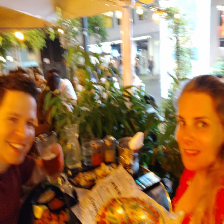

In [13]:
y=open_image('IMG_20190625_214419.jpg?dl=1').resize(224)
y

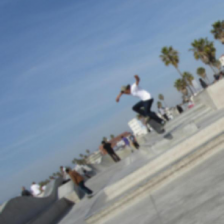

In [14]:
i=1
x=learn_gen.data.valid_ds[i]
x[0]

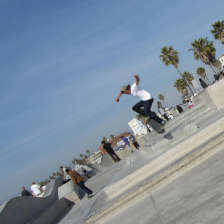

In [15]:
x[1]

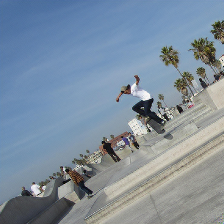

In [16]:
learn_gen.predict(x[i])[0]

In [17]:
y.resize(224)

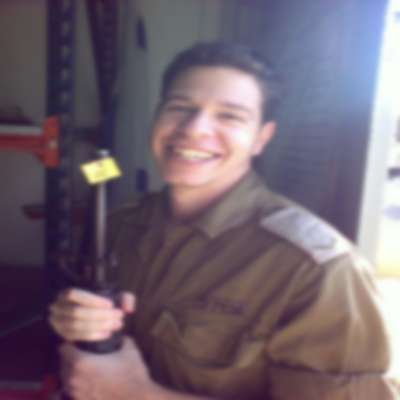

In [26]:
blurred.resize(400)

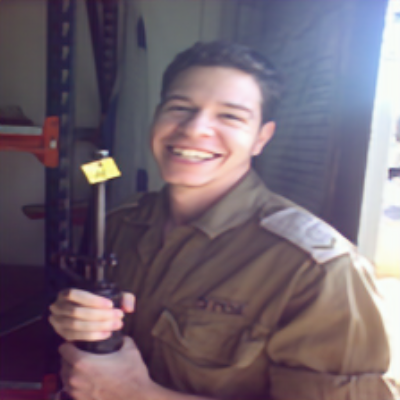

In [27]:
learn_gen.predict(blurred)[0].resize(400)

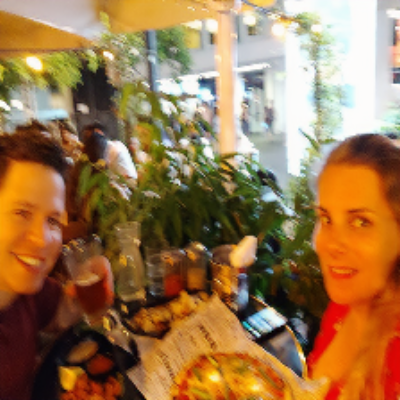

In [31]:
learn_gen.predict(y)[0].resize(400)

## Repeatable GAN Cycle

#### NOTE
Best results so far have been based on repeating the cycle below a few times (about 5-8?), until diminishing returns are hit (no improvement in image quality).  Each time you repeat the cycle, you want to increment that old_checkpoint_num by 1 so that new check points don't overwrite the old.  

In [ ]:
old_checkpoint_num = 0
checkpoint_num = old_checkpoint_num + 1
gen_old_checkpoint_name = gen_name + '_' + str(old_checkpoint_num)
gen_new_checkpoint_name = gen_name + '_' + str(checkpoint_num)
crit_old_checkpoint_name = crit_name + '_' + str(old_checkpoint_num)
crit_new_checkpoint_name= crit_name + '_' + str(checkpoint_num)

### Save Generated Images

In [ ]:
bs=8
sz=192

In [19]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False)

In [24]:
save_gen_images()

### Pretrain Critic

##### Only need full pretraining of critic when starting from scratch.  Otherwise, just finetune!

In [42]:
type(data_gen.train_ds[0][0]),type(blurred)

(fastai.vision.image.Image, fastai.vision.image.Image)

In [50]:
z=learn_critic.predict(y)

In [55]:
z[2].shape

torch.Size([25])

In [46]:
data_gen.train_ds[0][0].shape,blurred.shape

(torch.Size([3, 224, 224]), torch.Size([3, 192, 192]))

In [43]:
learn_critic.predict(data_gen.train_ds[0][0])

(Category StableModel_image_gen,
 tensor(0),
 tensor([-267.0840, -299.5158, -313.8600, -314.2234, -285.3148, -311.2363,
         -355.1984, -382.7117, -393.5919, -363.5157, -323.6315, -377.2540,
         -419.0096, -443.7685, -418.2993, -310.4798, -369.4360, -421.9591,
         -459.7294, -443.0665, -269.4695, -325.6338, -379.8817, -423.6620,
         -416.6608]))

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:203: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.114123,0.000000,1.000000,00:13
1,0.048481,0.000000,1.000000,00:06
2,0.027255,0.000000,1.000000,00:06
3,0.017112,0.000000,1.000000,00:06
4,0.011378,0.000000,1.000000,00:06
5,0.007827,0.000000,1.000000,00:06


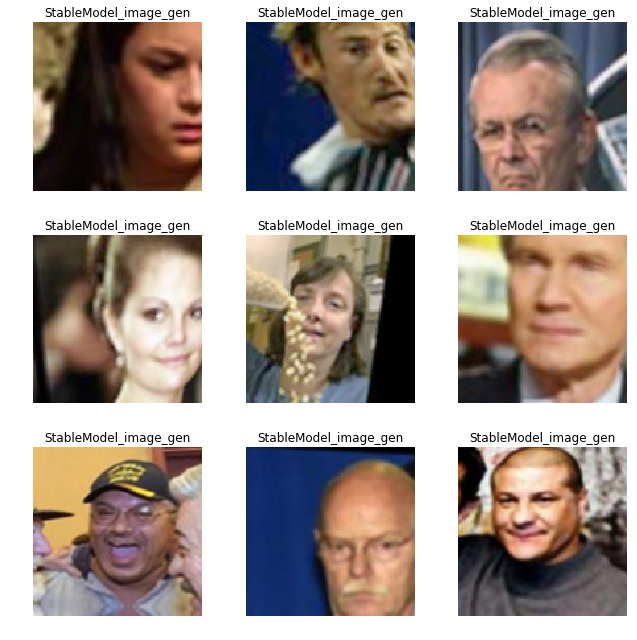

In [30]:
if old_checkpoint_num == 0:
    bs=64
    sz=128
    learn_gen=None
    gc.collect()
    data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)
    data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)
    learn_critic = colorize_crit_learner(data=data_crit, nf=256)
    #learn_critic.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=TENSORBOARD_PATH, name='CriticPre'))
    learn_critic.fit_one_cycle(6, 1e-3)
    learn_critic.save(crit_old_checkpoint_name)

In [56]:
bs=16
sz=192

In [57]:
data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:203: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


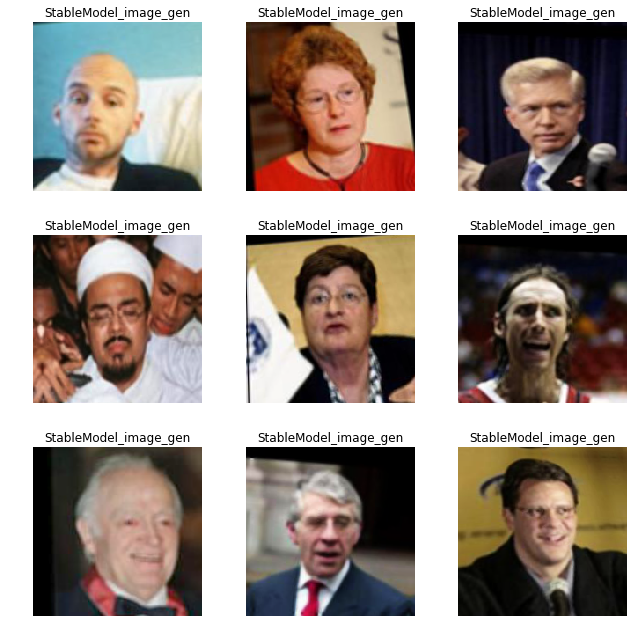

In [58]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [59]:
learn_critic = colorize_crit_learner(data=data_crit, nf=256).load(crit_old_checkpoint_name, with_opt=False)

In [61]:
#learn_critic.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=TENSORBOARD_PATH, name='CriticPre'))

In [62]:
learn_critic.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.000000,0.000000,1.000000,00:18
1,0.000000,0.000000,1.000000,00:16
2,0.000000,0.000000,1.000000,00:16
3,0.000000,0.000000,1.000000,00:16


In [63]:
learn_critic.save(crit_new_checkpoint_name)

In [64]:
crit_new_checkpoint_name

'StableModel_crit_1'

### GAN

In [65]:
learn_crit=None
learn_gen=None
gc.collect()

83

In [66]:
lr=2e-5
sz=192
bs=5

In [67]:
data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:203: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [68]:
learn_crit = colorize_crit_learner(data=data_crit, nf=256).load(crit_new_checkpoint_name, with_opt=False)

In [69]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False)

In [71]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.0,1.5), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.9)), wd=1e-3)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
#learn.callback_fns.append(partial(GANTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GanLearner', visual_iters=100))
learn.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_iters=100))

#### Instructions:  
Find the checkpoint just before where glitches start to be introduced.  This is all very new so you may need to play around with just how far you go here with keep_pct.

In [72]:
learn.data = get_data(sz=sz, bs=bs, keep_pct=0.03)
learn_gen.freeze_to(-1)
learn.fit(1,lr)

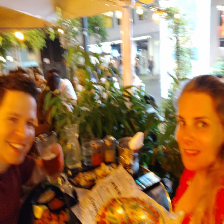

In [28]:
y

In [29]:
learn.predict(y)[0].resize(400)

NameError: name 'learn' is not defined

In [76]:
get_image_colorizer

NameError: name 'get_image_colorizer' is not defined